# **SSCS - Training**

Developed by André Paiva

Based on SSCS Dataset created by Helena Cuesta and Emilia Gómez

## 1 - Initialization

In [ ]:
import numpy as np
import tensorflow as tf
import sscs

In [ ]:
#Model Type: 0 = VoasCNN, 1 = Downsample, 2 = Mask, 3 = MaskV2, 4 = DownsampleV2
MODEL_TYPE = 2
TRAINING_NUMBER = 1
SAVE_MODEL = True
LOAD_MODEL = True
TRAIN_MODEL = False
MODEL_SUMMARY = False
L_RATE = 5e-3
EPOCHS = 30

F_SCORE_PRECOMPUTE = False
F_SCORE_LOAD = True
F_SCORE_PLOTS = True

## 2 - Download and extract dataset SSCS

In [ ]:
sscs.download()

## 3 - Model (Training/Loading)

In [ ]:
ds_train = sscs.get_dataset(split='train', end_index=1000)
ds_val = sscs.get_dataset(split='validate', end_index=300)
ds_test = sscs.get_dataset(split='test', end_index=300)

In [ ]:
if (MODEL_TYPE == 0):
    ckpt_dir = './Checkpoints/voas_treino' + str(TRAINING_NUMBER) + '.keras'
    model = sscs.voas_cnn_model(l_rate = L_RATE)
    log_folder = 'voas_cnn'
elif (MODEL_TYPE == 1):
    ckpt_dir = './Checkpoints/downsample_voas_treino' + str(TRAINING_NUMBER) + '.keras'
    model = sscs.downsample_voas_cnn_model(l_rate = L_RATE)
    log_folder = 'downsample_voas_cnn'
elif (MODEL_TYPE == 2):
    ckpt_dir = './Checkpoints/mask_voas_treino' + str(TRAINING_NUMBER) + '.keras'
    model = sscs.mask_voas_cnn_model(l_rate = L_RATE)
    log_folder = 'mask_voas_cnn'
elif (MODEL_TYPE == 3):
    ckpt_dir = './Checkpoints/mask_voas_v2_treino' + str(TRAINING_NUMBER) + '.keras'
    model = sscs.mask_voas_cnn_v2_model(l_rate = L_RATE)
    log_folder = 'mask_voas_v2'
elif (MODEL_TYPE == 4):
    ckpt_dir = './Checkpoints/downsample_voas_v2_treino' + str(TRAINING_NUMBER) + '.keras'
    model = sscs.downsample_voas_cnn_v2_model(l_rate = L_RATE)
    log_folder = 'downsample_voas_v2'
else:
    ckpt_dir = './Checkpoints/voas_treino' + str(TRAINING_NUMBER) + '.keras'
    model = sscs.voas_cnn_model(l_rate = L_RATE)
    log_folder = 'voas_cnn'

f_score_dir = './Evaluation_Data/' + log_folder + '_f-scores_treino' + str(TRAINING_NUMBER) + '.npy'

if MODEL_SUMMARY:
    print(model.summary())

In [ ]:
if LOAD_MODEL:
    sscs.load_weights(model, ckpt_dir=ckpt_dir)

if TRAIN_MODEL:
    sscs.train(model, ds_train, ds_val, epochs=EPOCHS, save_model=SAVE_MODEL,
               ckpt_dir=ckpt_dir, log_folder=log_folder)  

## 4 - Evaluation with F-Score

In [ ]:
if(F_SCORE_PRECOMPUTE):
    f_scores = sscs.f_score_test_precompute(model, save_dir=f_score_dir)

if(F_SCORE_LOAD):
    f_scores = np.load(f_score_dir)
    print(f_scores.shape)

In [ ]:
if(F_SCORE_PLOTS):
    sscs.joint_f_histograms(f_scores, title=model.name)

In [ ]:
if(F_SCORE_PLOTS):
    sscs.voice_f_histograms(f_scores, title=model.name)

In [ ]:
if(F_SCORE_PLOTS):
    sscs.boxplot(f_scores, title=model.name)

## 5 - Visualizing the "mask" (only for mask implementations)

In [ ]:
print(len(model.layers))

In [12]:
if(MODEL_TYPE == 2 or MODEL_TYPE == 3):
    upscale_layer = -1

    for i in range(len(model.layers)):
        if model.layers[i].name == 'upscale':
            upscale_layer = i
            break

    mask_activations    = tf.keras.models.Model(inputs=model.inputs,
                                                outputs=[   model.layers[upscale_layer].output,
                                                            model.layers[upscale_layer + 1].output])

    #mask_activations.summary()

    rand_song = sscs.pick_random_song(split='test')
    mix, s, a, t, b = sscs.read_all_voice_splits(rand_song)

    upscale, mask = mask_activations.predict(mix)
    upscale = np.moveaxis(upscale, 0, 1).reshape(360, -1, 16)
    mask = np.moveaxis(mask, 0, 1).reshape(360, -1, 16)
    mix = np.moveaxis(mix, 0, 1).reshape(360, -1)
    s = np.moveaxis(s, 0, 1).reshape(360, -1)
    a = np.moveaxis(a, 0, 1).reshape(360, -1)
    t = np.moveaxis(t, 0, 1).reshape(360, -1)
    b = np.moveaxis(b, 0, 1).reshape(360, -1)

(pid=271270) 2023-07-12 01:20:43,755	INFO worker.py:1474 -- Calling ray.init() again after it has already been called.
(pid=271270) sh: 1: load_ext: not found
2023-07-12 01:20:45.733103: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:434] Loaded cuDNN version 8600
2023-07-12 01:20:46.710248: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


3/3 [==============================] - 3s 66ms/step


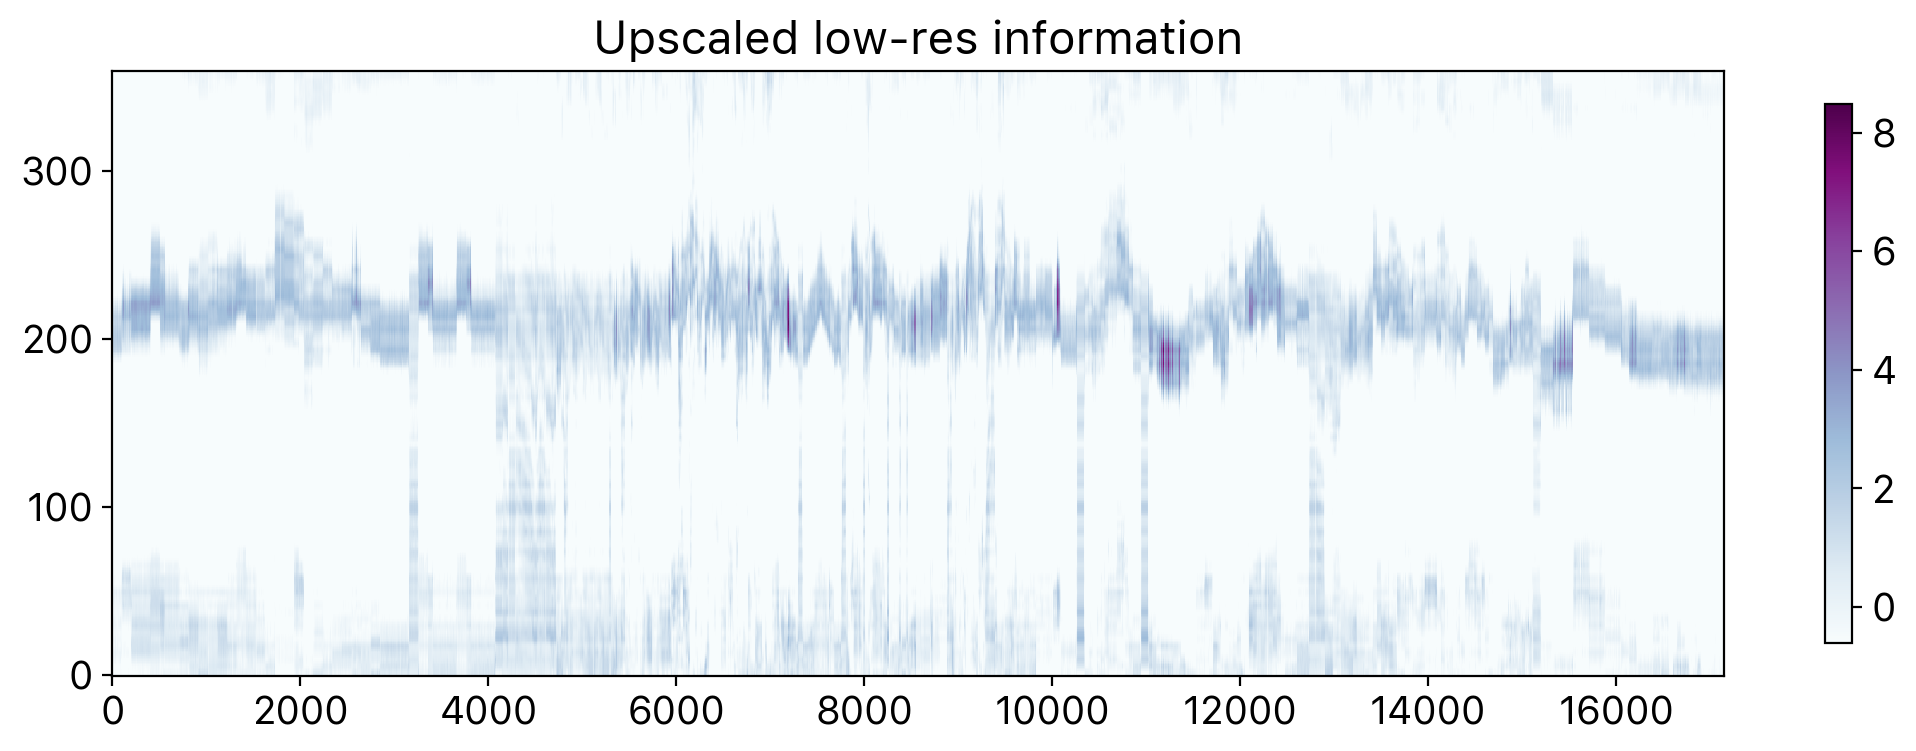

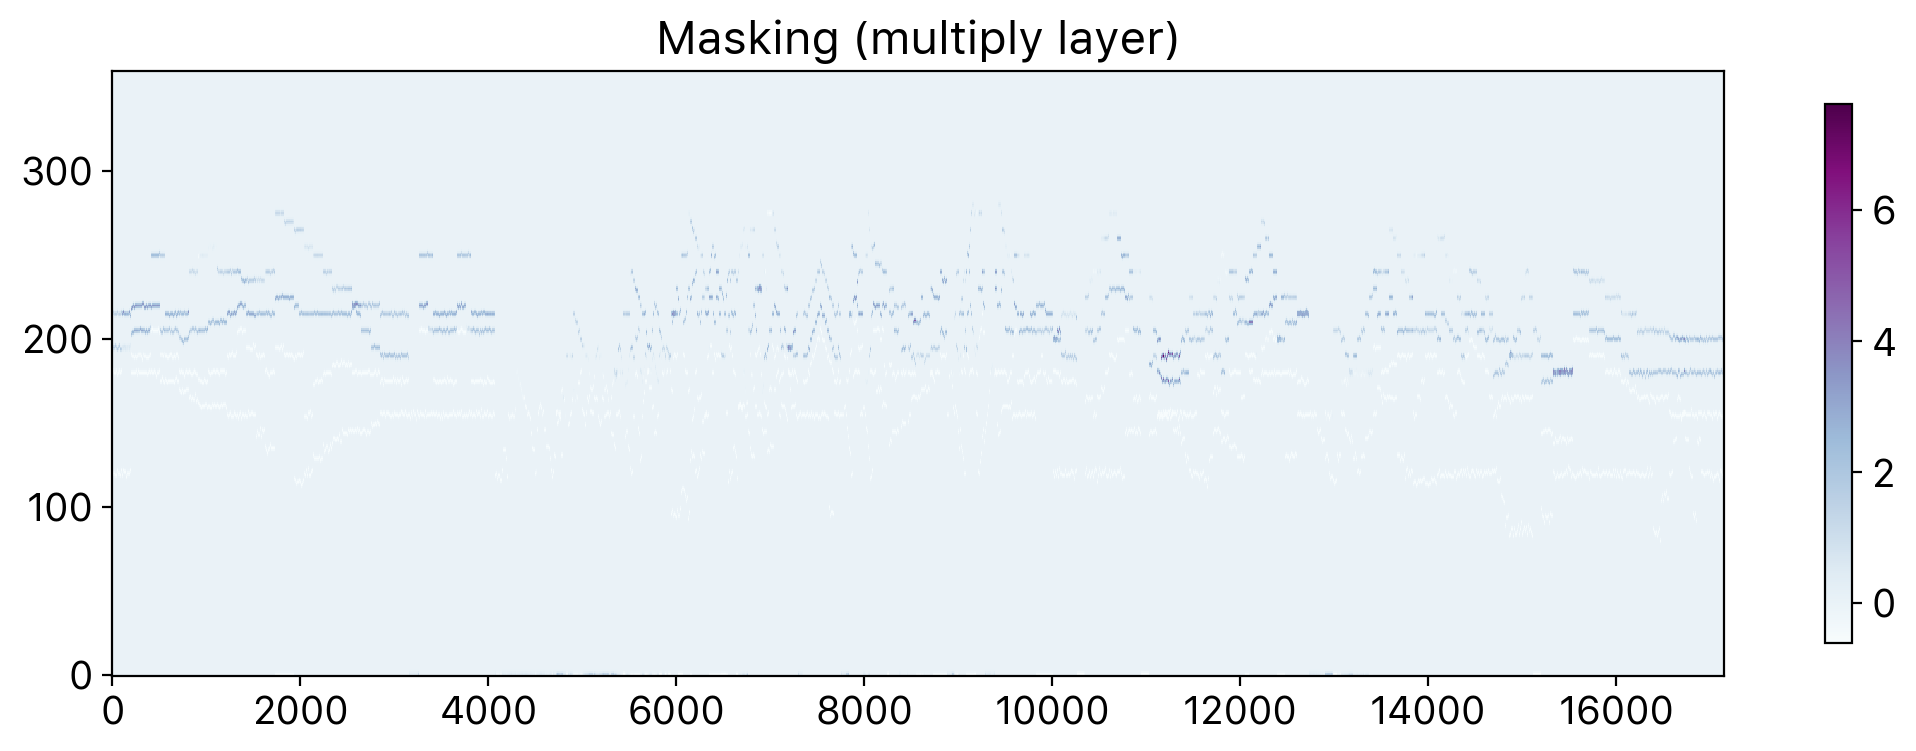

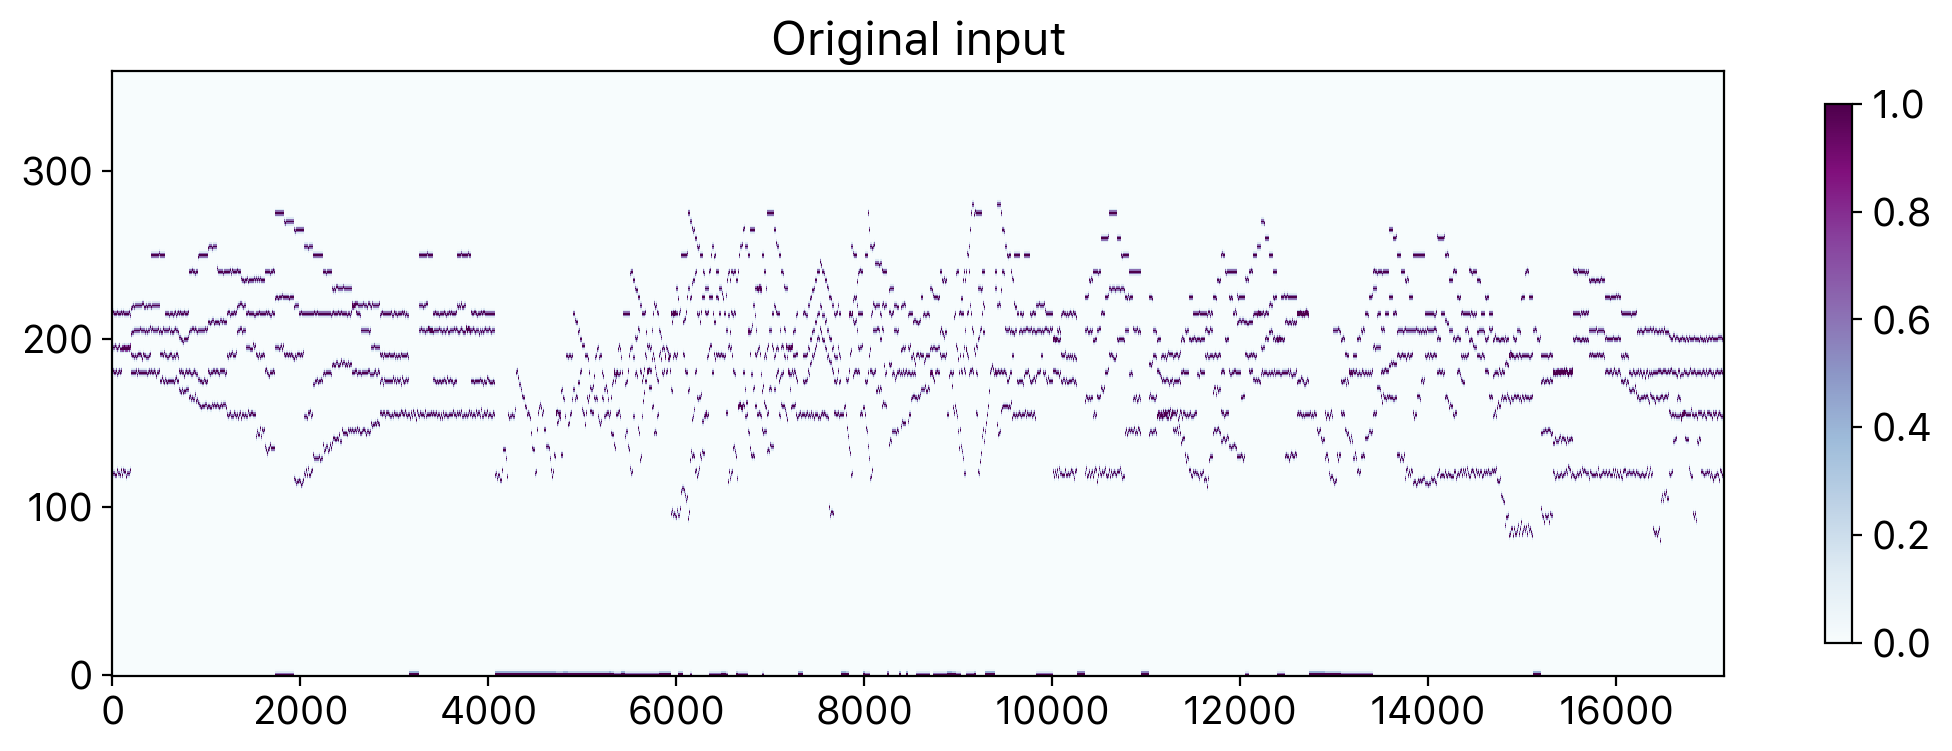

In [13]:
if(MODEL_TYPE == 2 or MODEL_TYPE == 3):
    idx = 11
    sscs.plot(upscale[:, :, idx], colorbar=True, title='Upscaled low-res information')
    sscs.plot(mask[:, :, idx], colorbar=True, title='Masking (multiply layer)')
    sscs.plot(mix, colorbar=True, title='Original input')

## 6 - Playground

4/4 [==============================] - 1s 288ms/step
F-Scores:
Soprano: 0.9904179521367547
Alto: 0.9809695012820538
Tenor: 0.9511551316239343
Bass: 0.9635082299145324



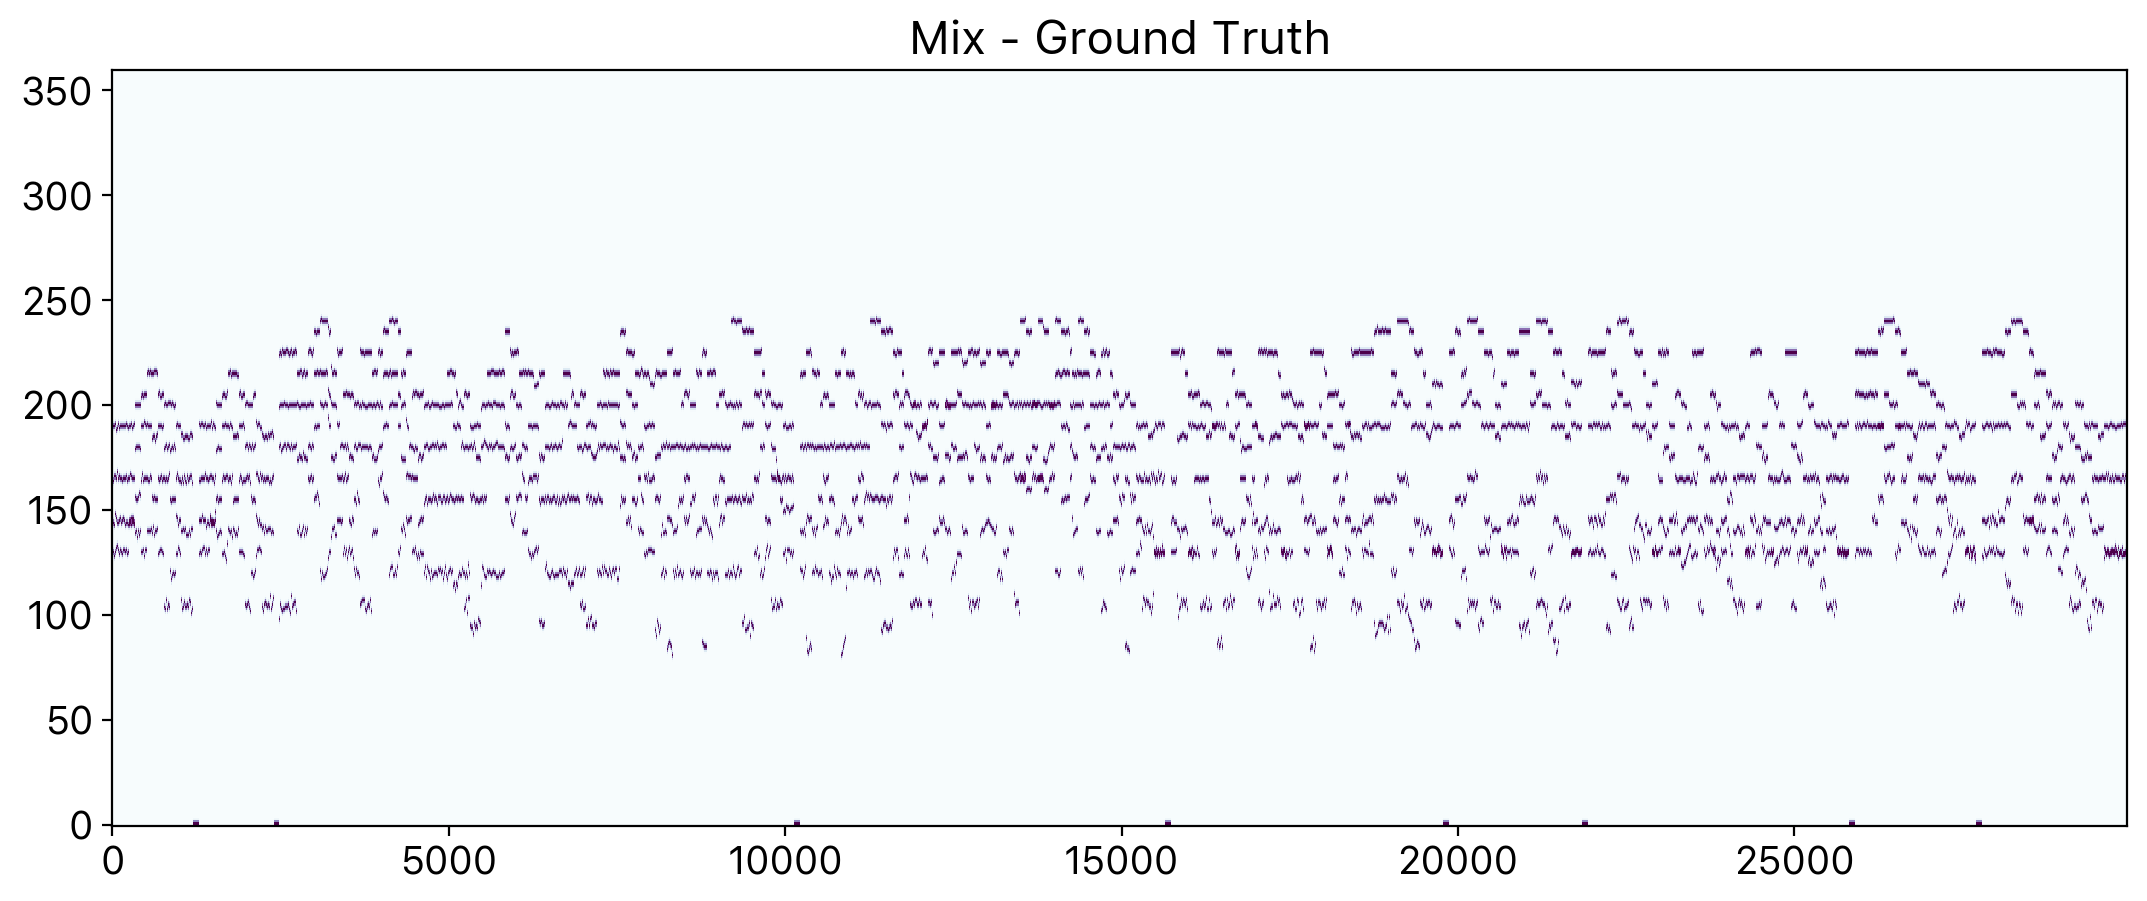

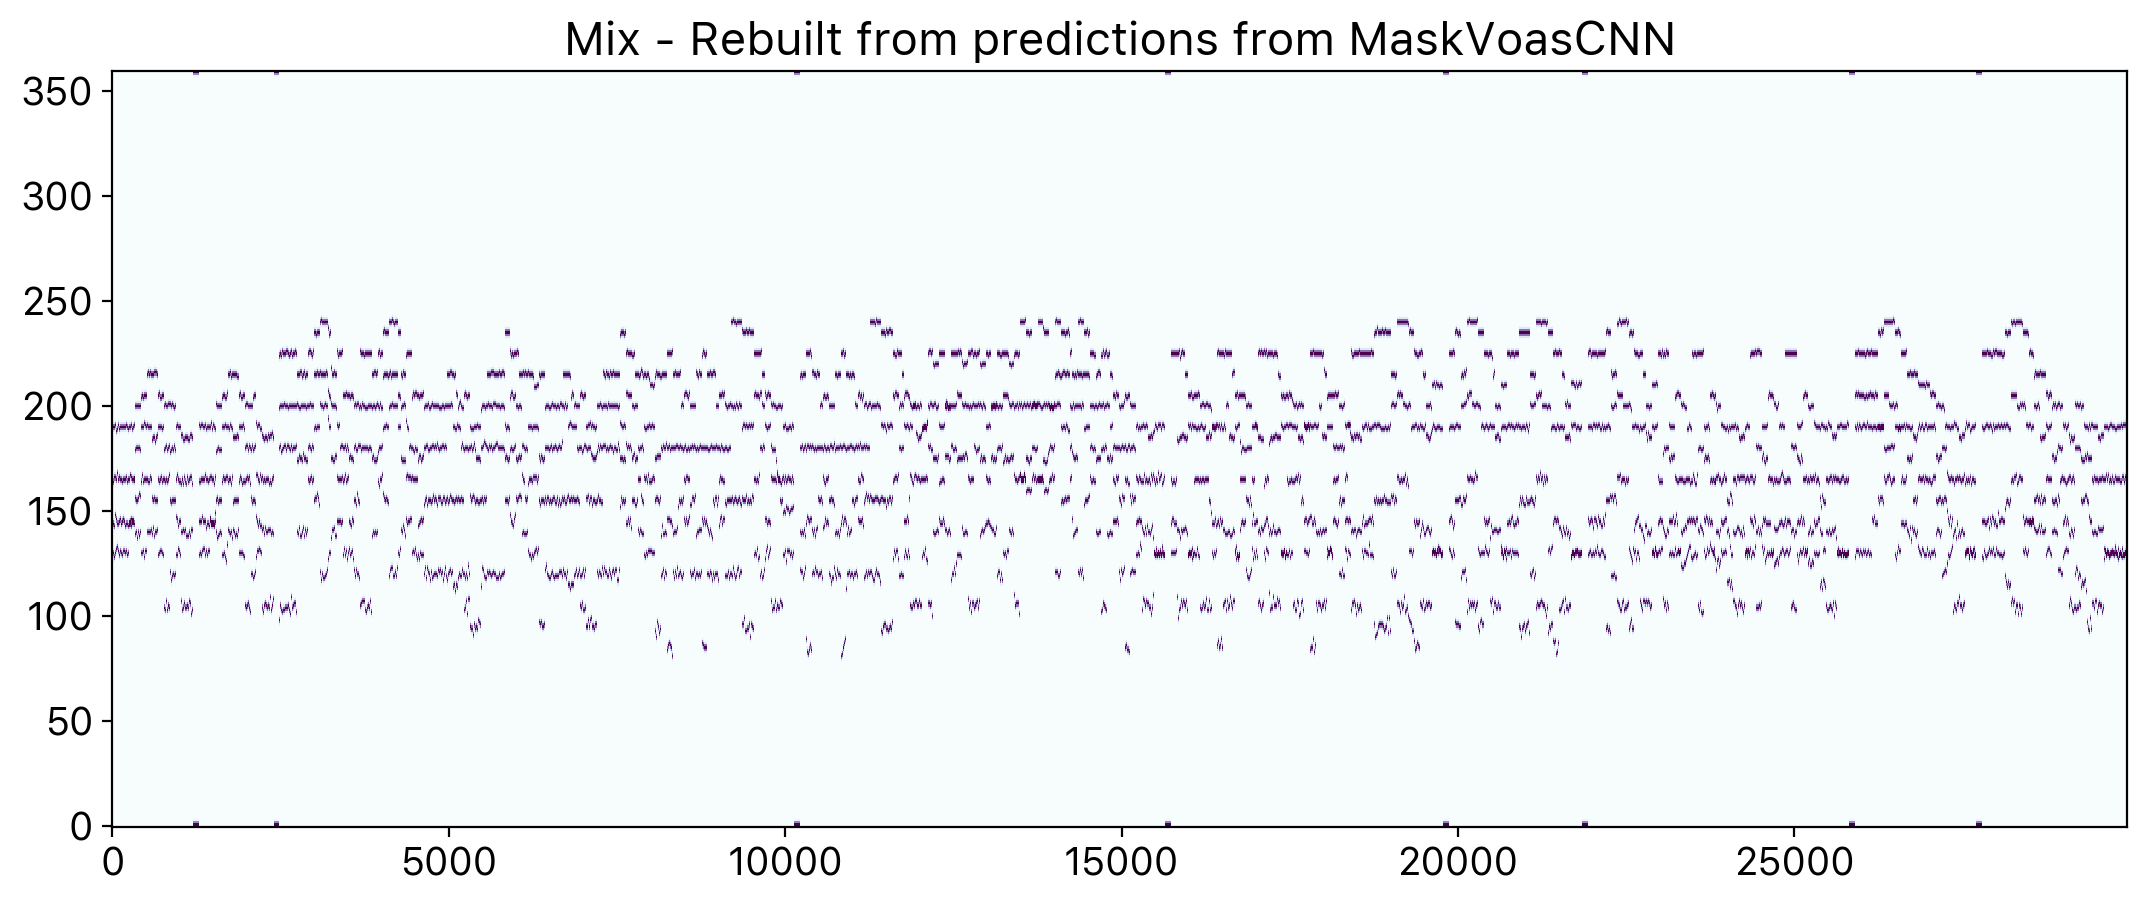

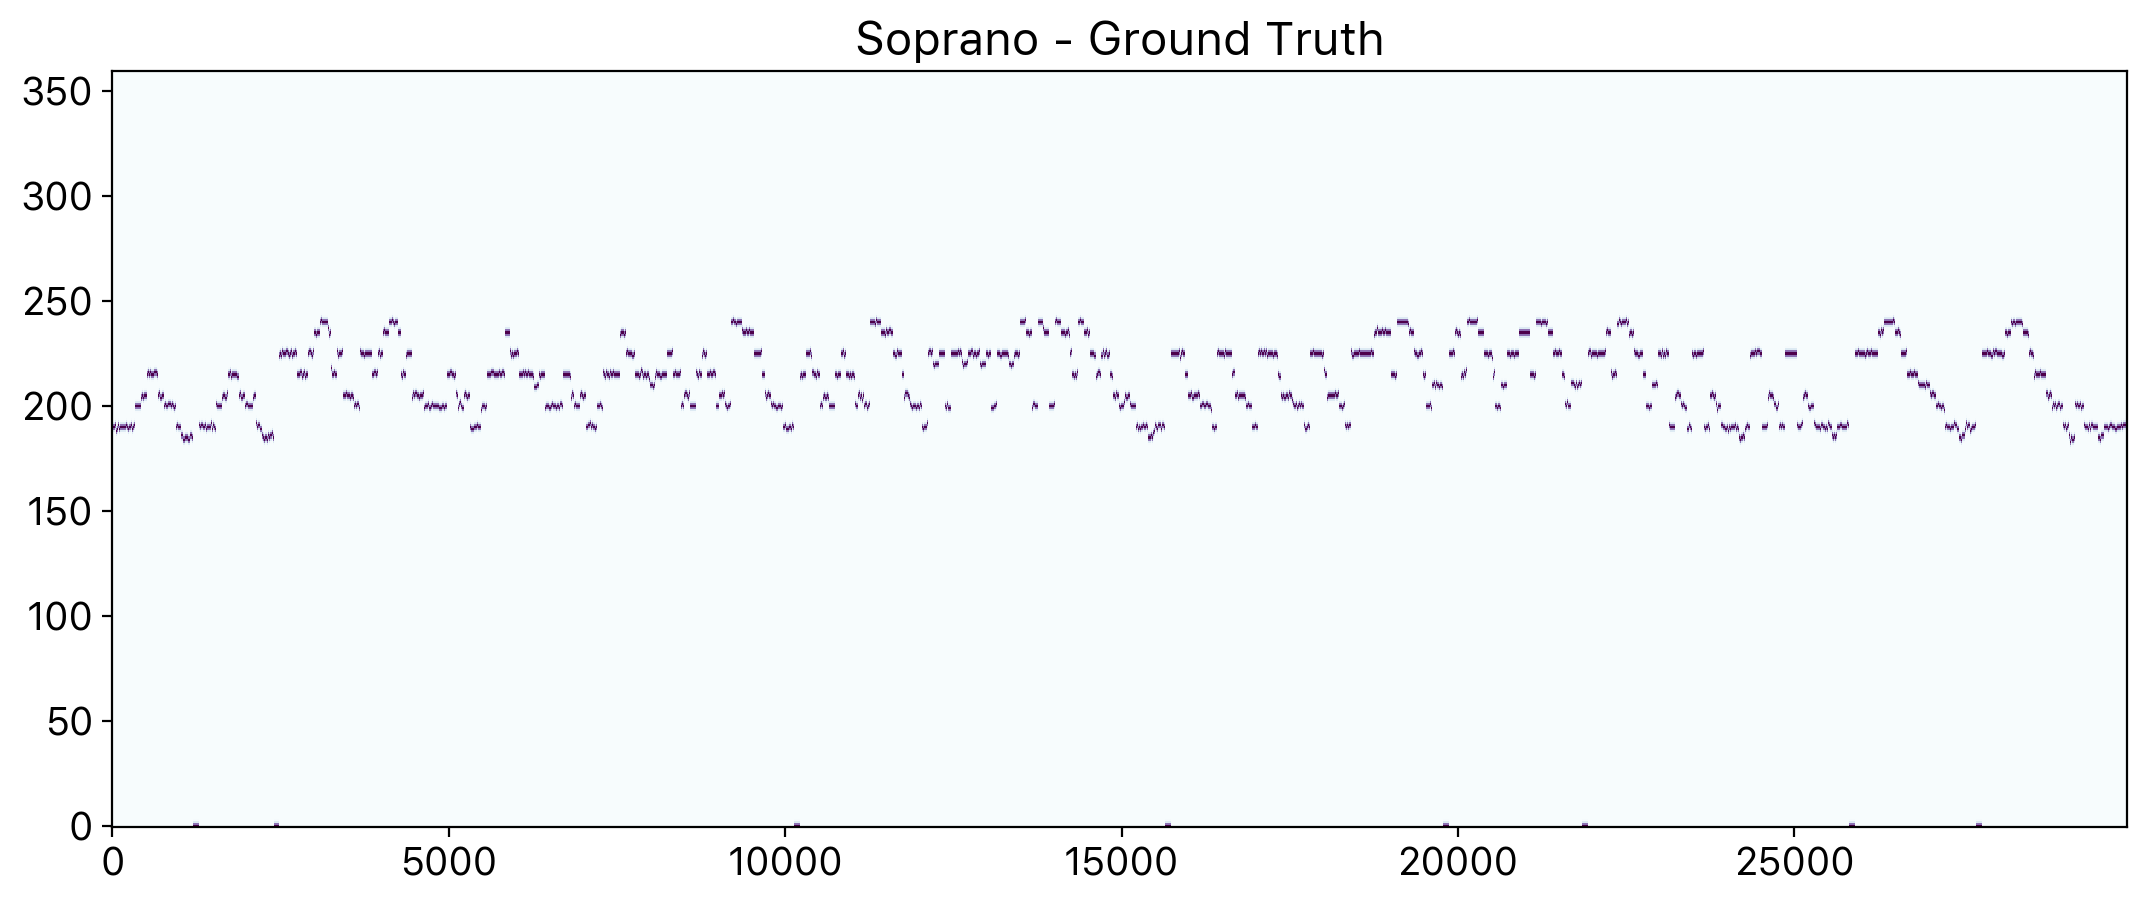

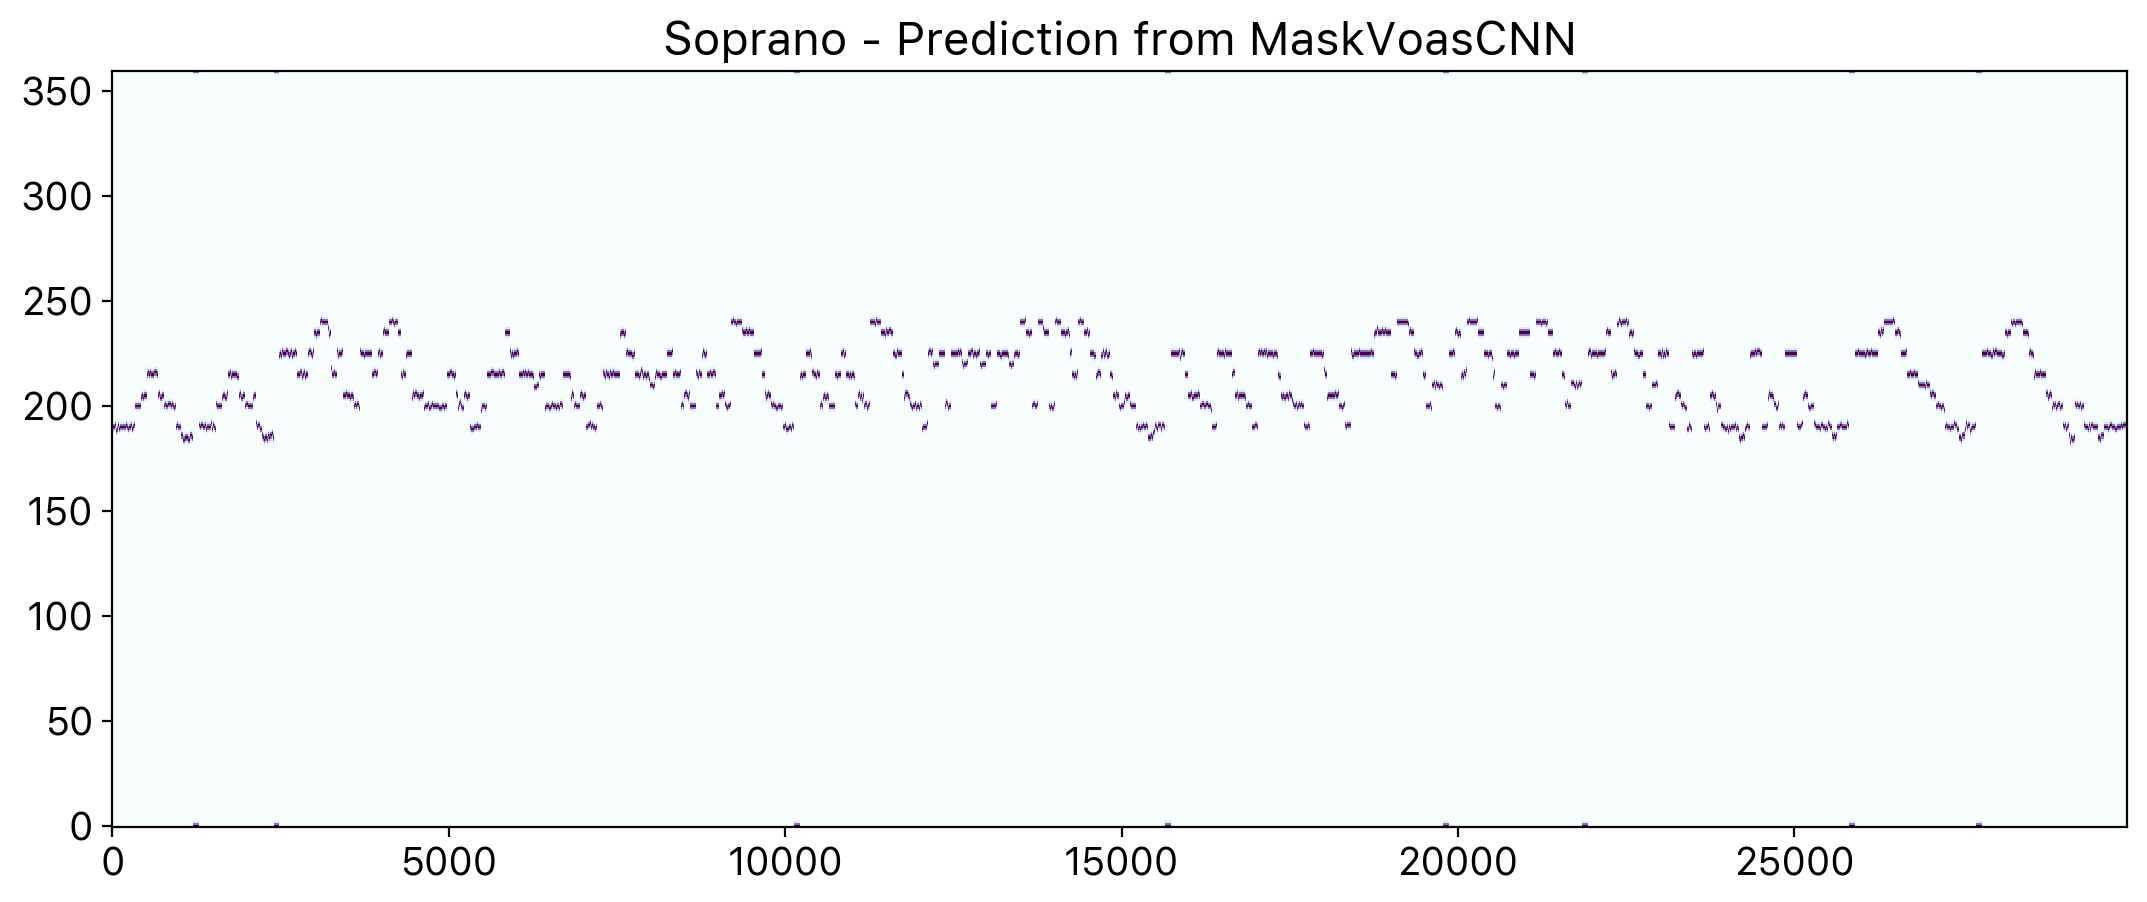

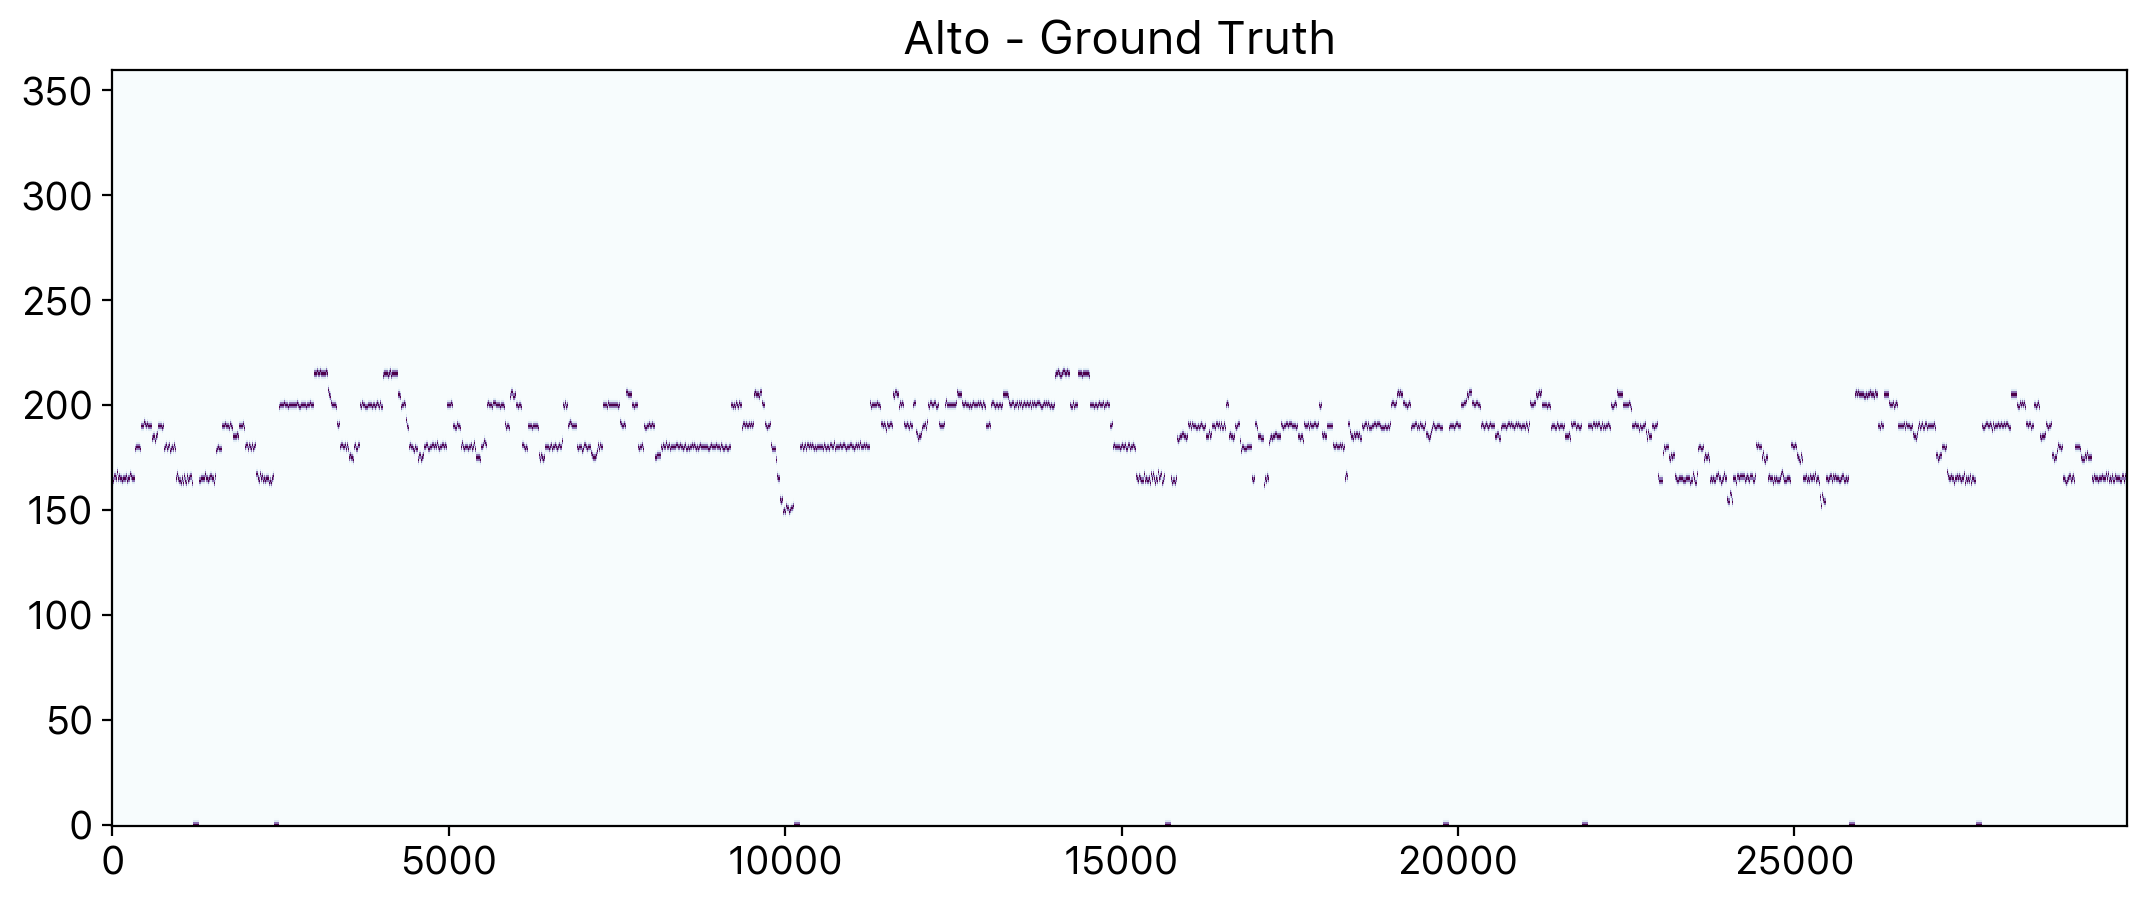

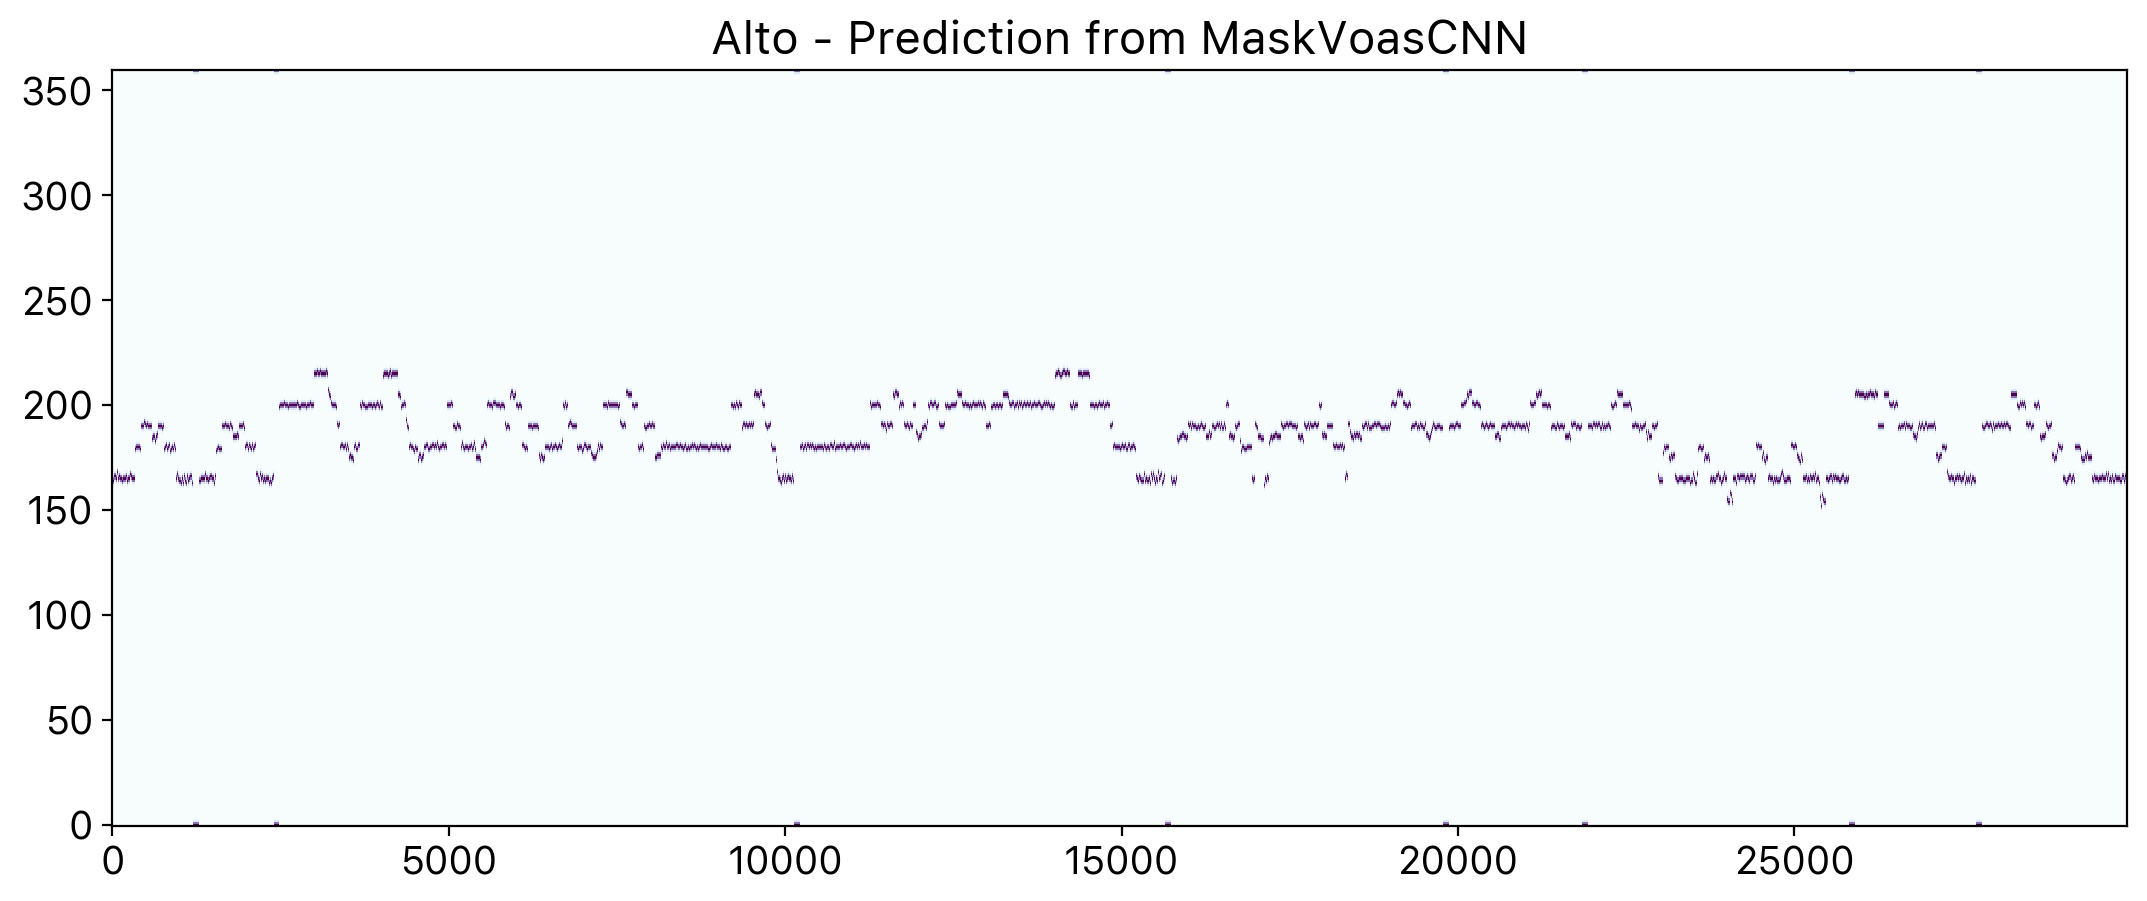

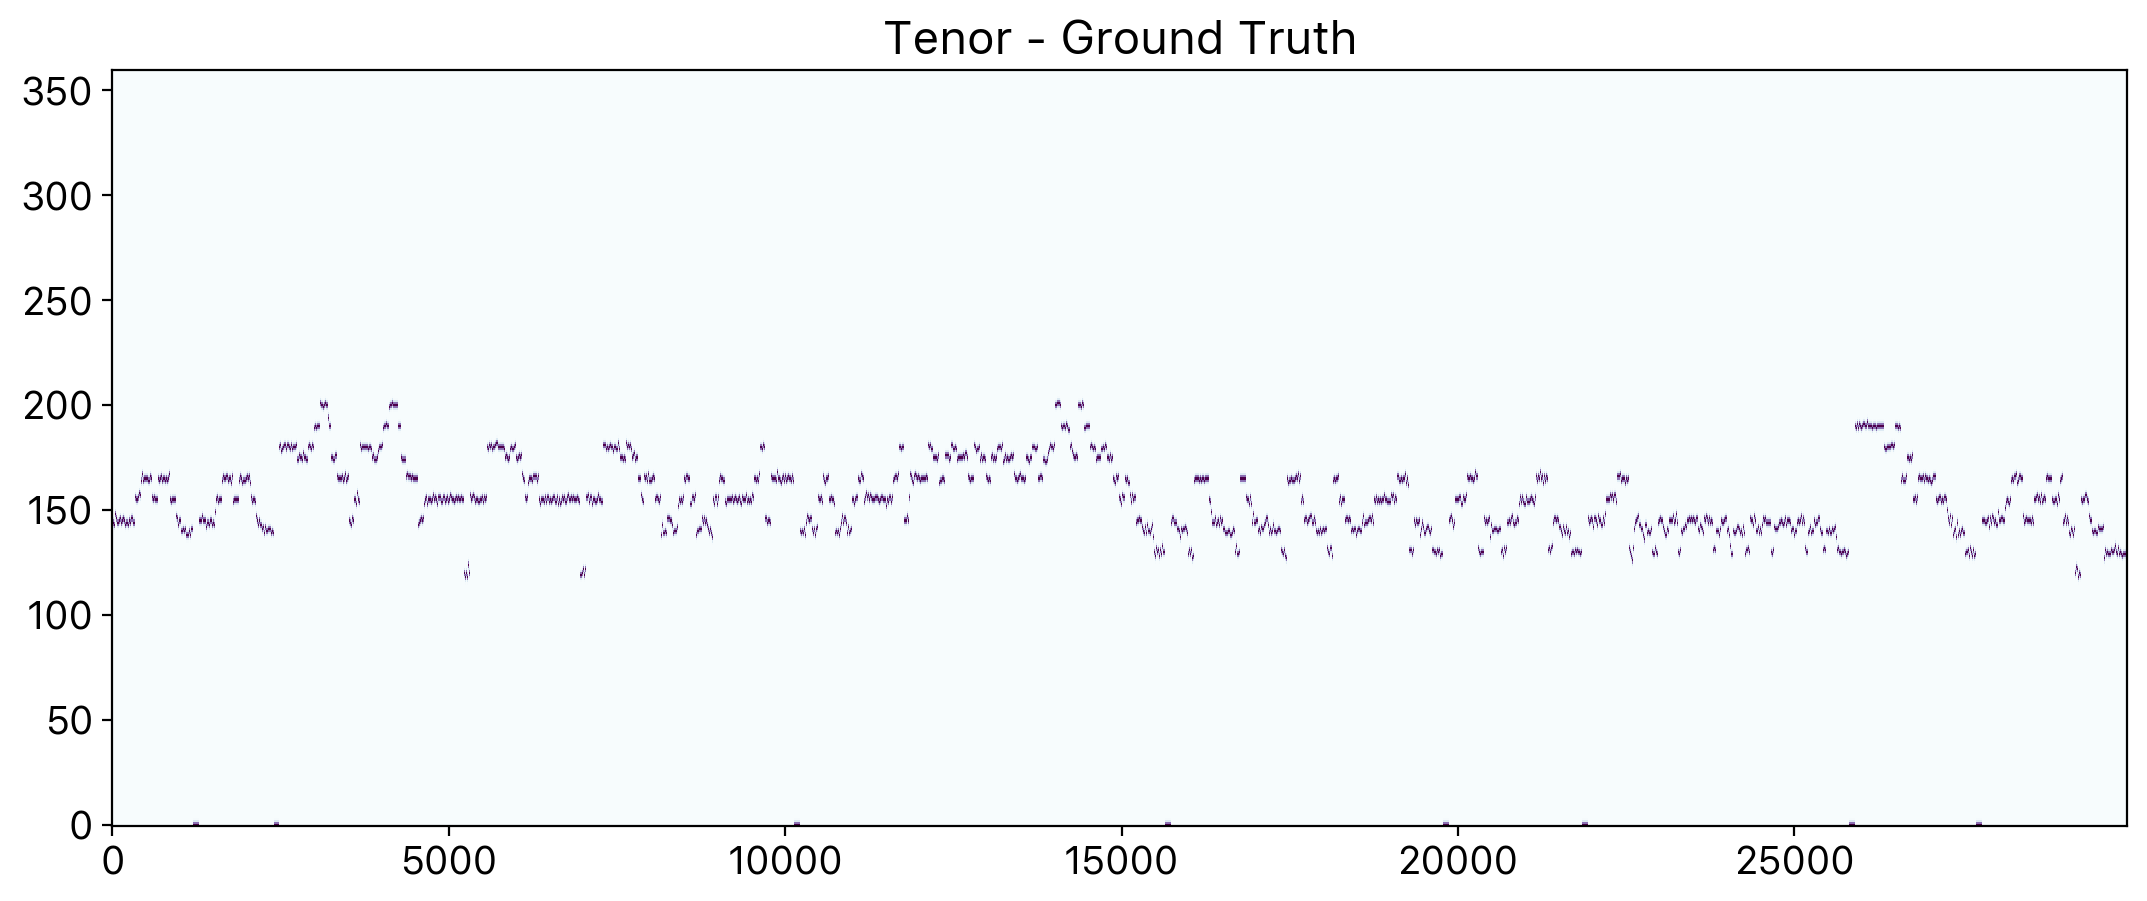

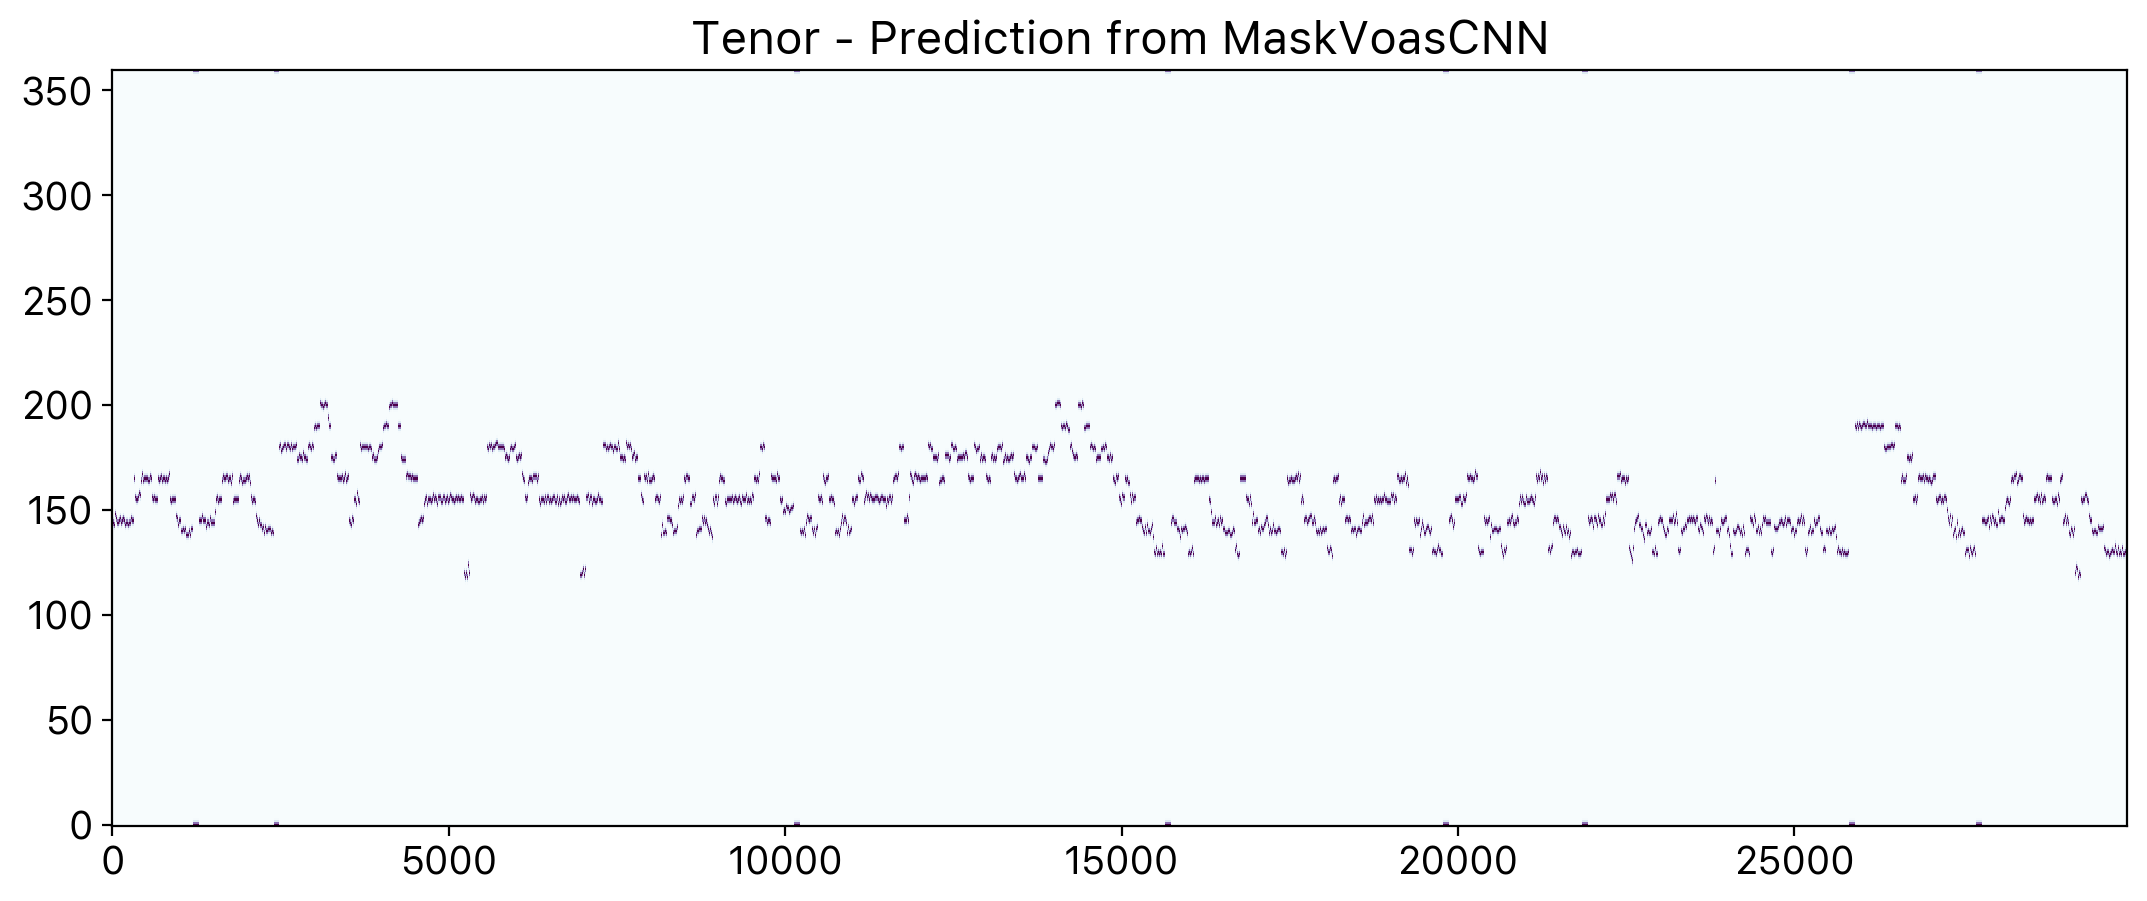

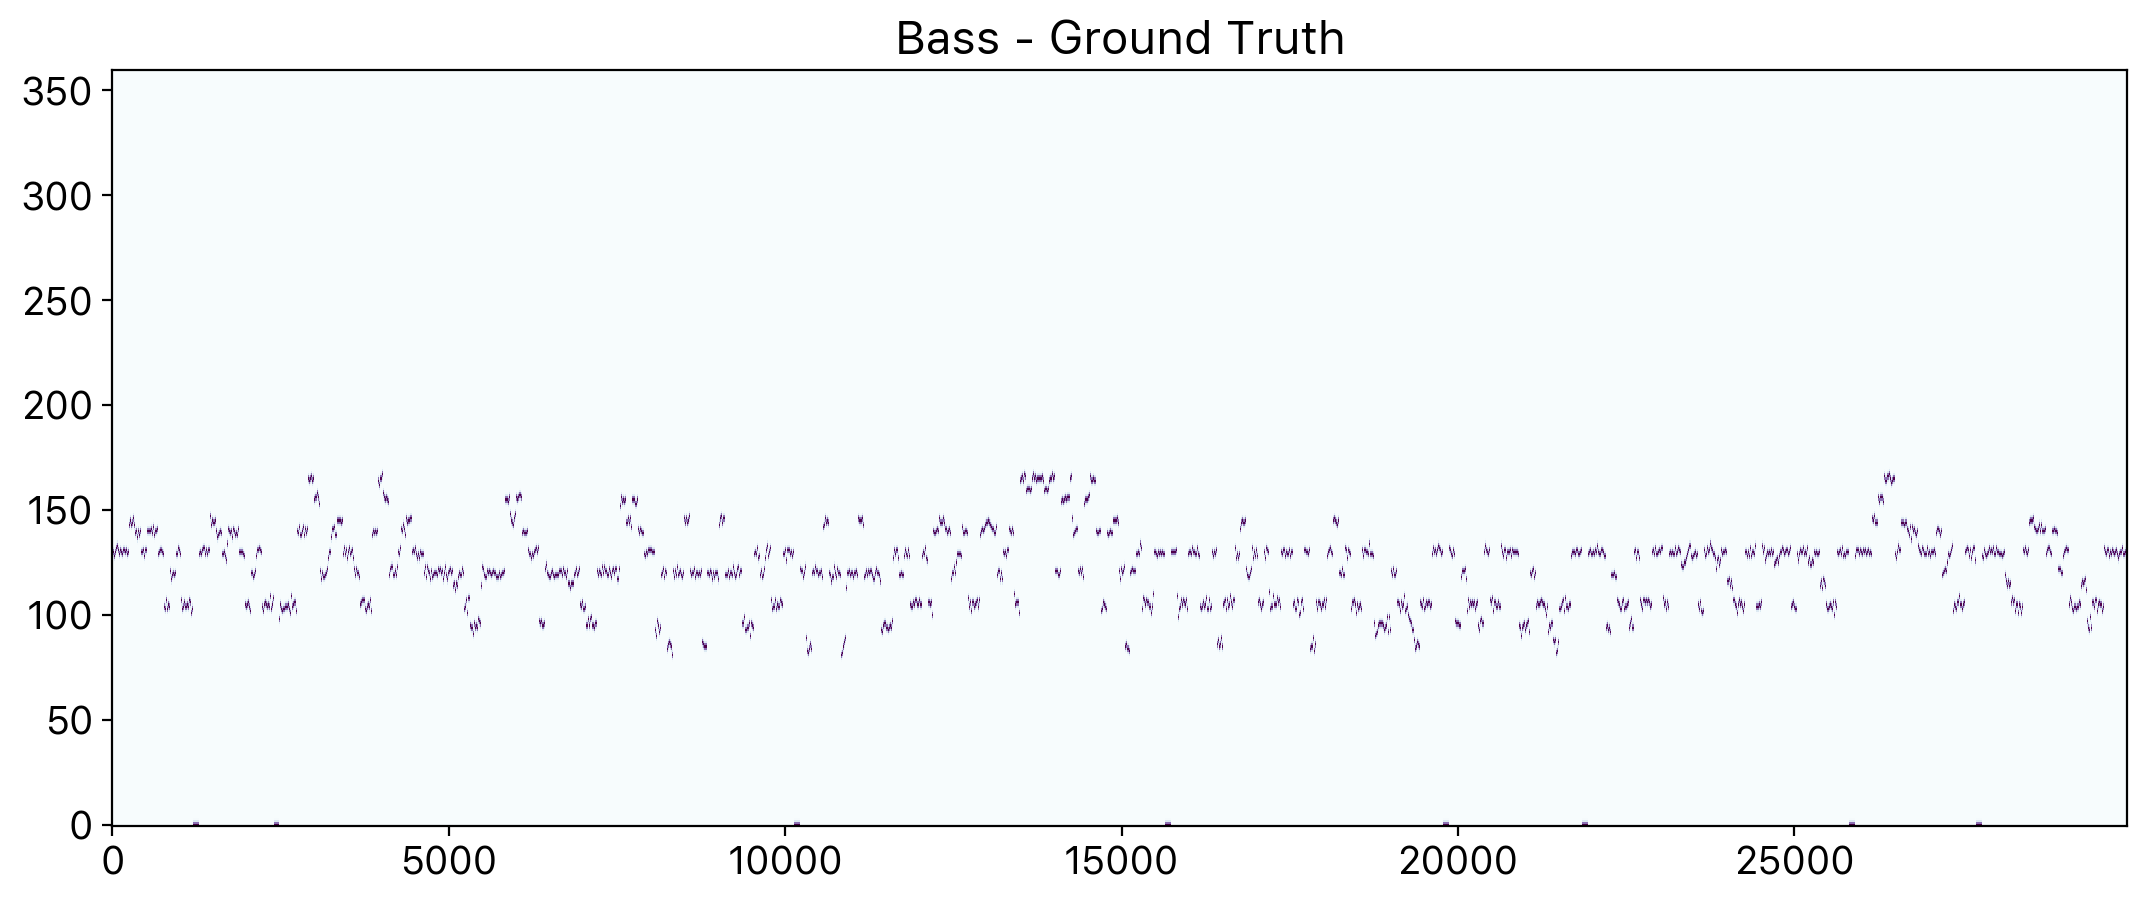

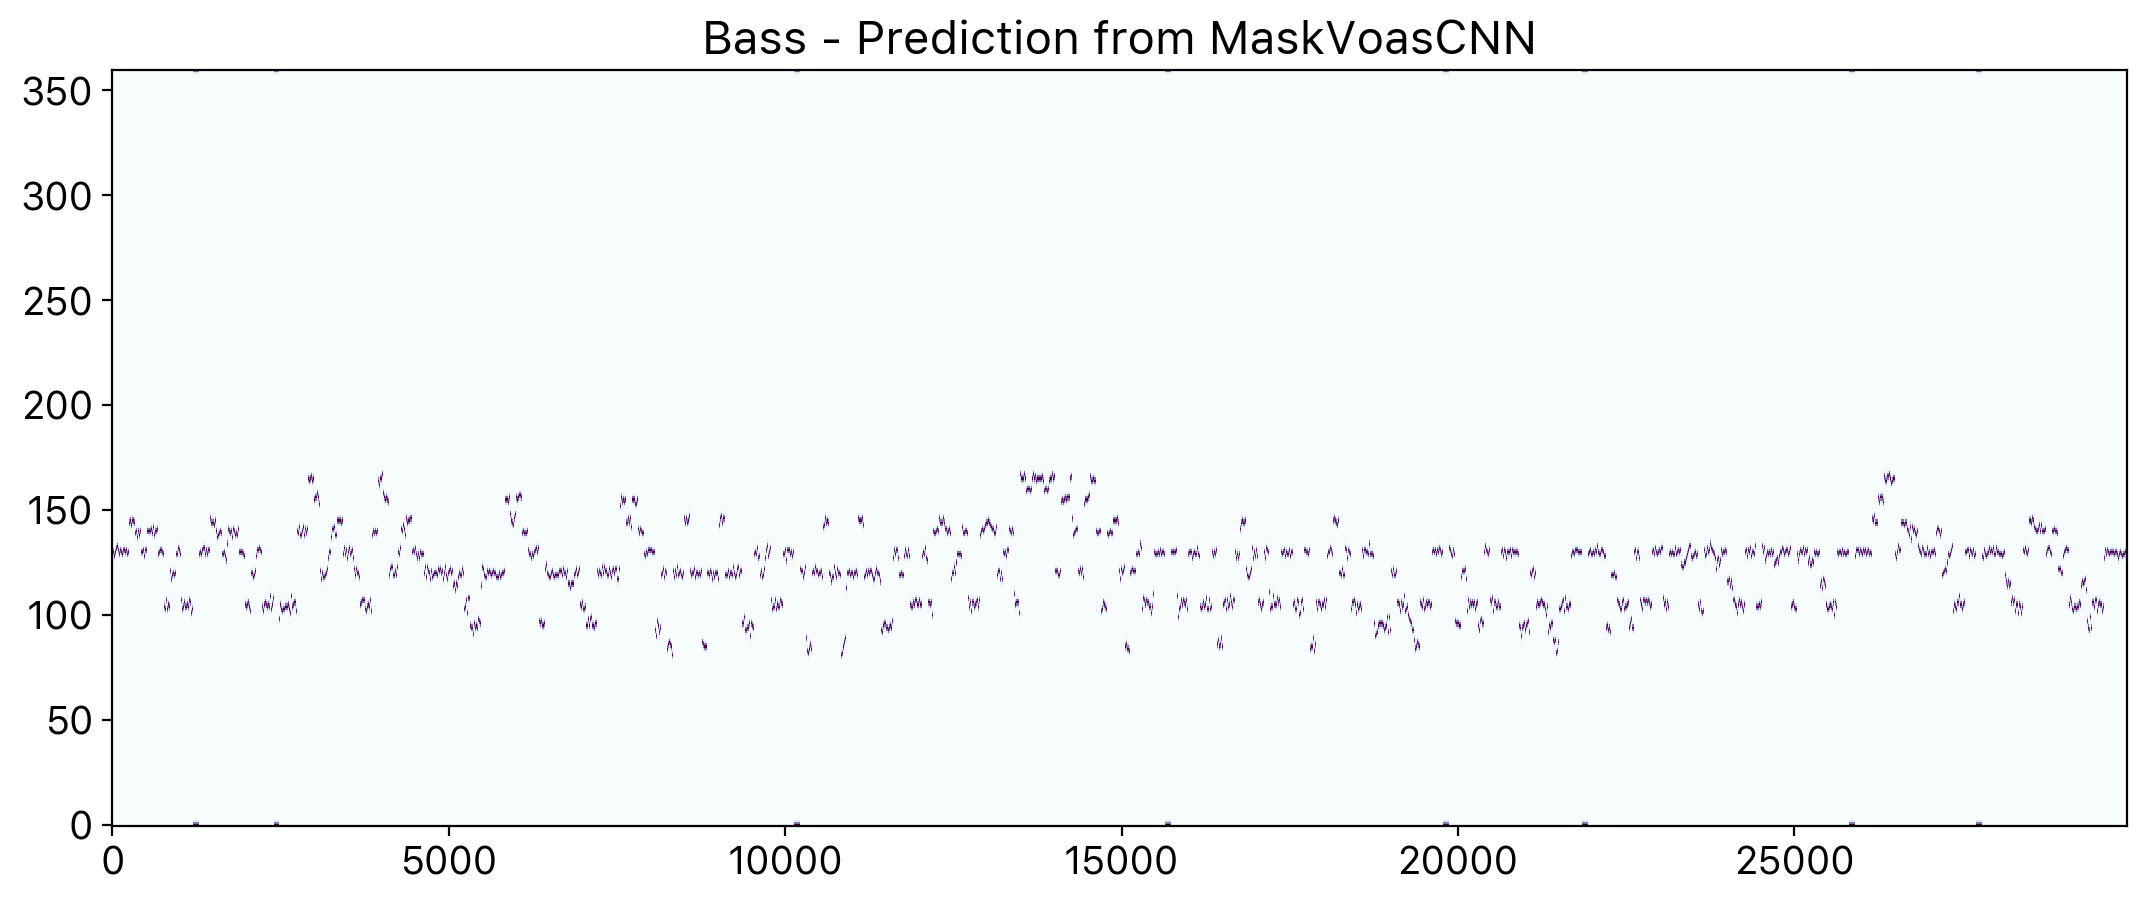

In [16]:
sscs.playground(model)